In [1]:
# Install required packages.

# conda create -n gnn_mol python==3.10
# pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
# pip install torch_geometric==2.6.1
# pip install matplotlib==3.9.2
# pip install torch_scatter torch_sparse torch_cluster -f https://data.pyg.org/whl/torch-2.4.0+cu124.html

In [2]:
# Import required packages
import os 
import torch 
import matplotlib.pyplot as plt
import networkx as nx

print(torch.__version__) # 2.5.1+cu124
print(torch.version.cuda) # 12.4

2.4.0+cu124
12.4


In [3]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}')
print(f'# graphs: {len(dataset)}')
print(f'# features: {dataset.num_features}')
print(f'# classes: {dataset.num_classes}')

Dataset: KarateClub()
# graphs: 1
# features: 34
# classes: 4


In [4]:
data = dataset[0]

print(data)
# dir(data)
print("=========")

# gather info
print(f"# nodes: {data.num_nodes}")
print(f"# edges: {data.num_edges}")
print(f'avg node degree: {data.num_edges/data.num_nodes:.2f}')
print(f'# training nodes: {data.train_mask.sum()}')
print(f'training node label rate: {int(data.train_mask.sum())/data.num_nodes:.2f}')
print(f'has isolated node: {data.has_isolated_nodes()}')
print(f'has self loops: {data.has_self_loops()}')
print(f'is undirected: {data.is_undirected()}')

# print(data.train_mask)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
# nodes: 34
# edges: 156
avg node degree: 4.59
# training nodes: 4
training node label rate: 0.12
has isolated node: False
has self loops: False
is undirected: True


In [5]:
print(len(data.edge_index.t()))
print((data.edge_index.t()[:10]))

156
tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11]])


In [6]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False, node_color=color, cmap="Set2")
    plt.show()

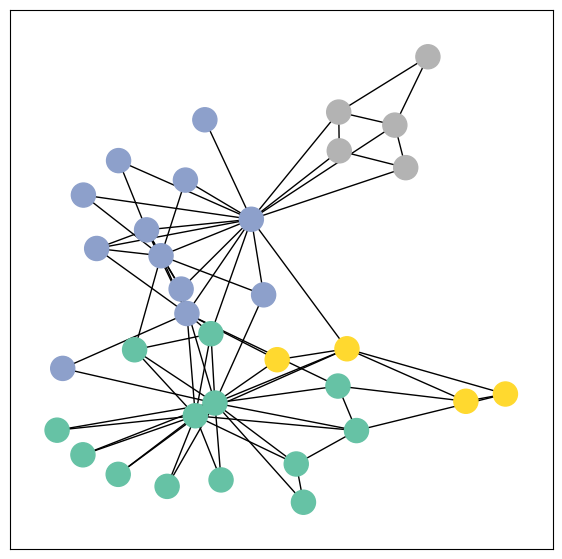

In [7]:
from torch_geometric.utils import to_networkx

G = to_networkx(data,to_undirected=True)
visualize_graph(G, color=data.y)

### implement GNN model using GCN

In [8]:
dataset.num_classes, dataset.num_features

(4, 34)

In [9]:
import torch
import numpy as np
from torch.nn import Linear 
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features,4)
        self.conv2 = GCNConv(4,4)
        self.conv3 = GCNConv(4,2)
        self.classifier = Linear(2, dataset.num_classes)
    
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()

        # apply linear classifier
        out = self.classifier(h)
        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [10]:
dataset, data

(KarateClub(), Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34]))

In [11]:
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    
    h = h.detach().cpu().numpy()
    plt.scatter(h[:,0], h[:,1], s=140, c=color, cmap="Set2")

    x_min, x_max = h[:, 0].min(), h[:, 0].max()
    y_min, y_max = h[:, 1].min(), h[:, 1].max()

    x_ticks = np.linspace(x_min, x_max, 10)
    y_ticks = np.linspace(y_min, y_max, 10)
    
    plt.xticks(x_ticks, labels=[f'{x:.2f}' for x in x_ticks], fontsize=10)
    plt.yticks(y_ticks, labels=[f'{y:.2f}' for y in y_ticks], fontsize=10)

    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss{loss.item():.4f}', fontsize=16)
    plt.show()

In [12]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [13]:
data.y[data.train_mask]

tensor([1, 3, 0, 2])

Embedding shape: [34, 2]


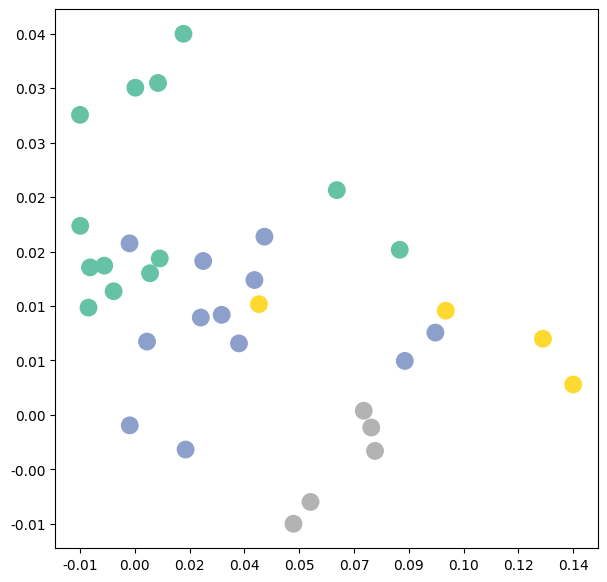

In [14]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

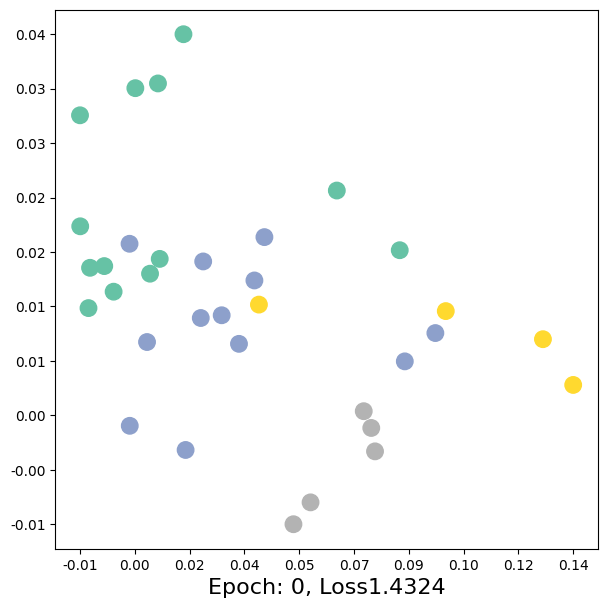

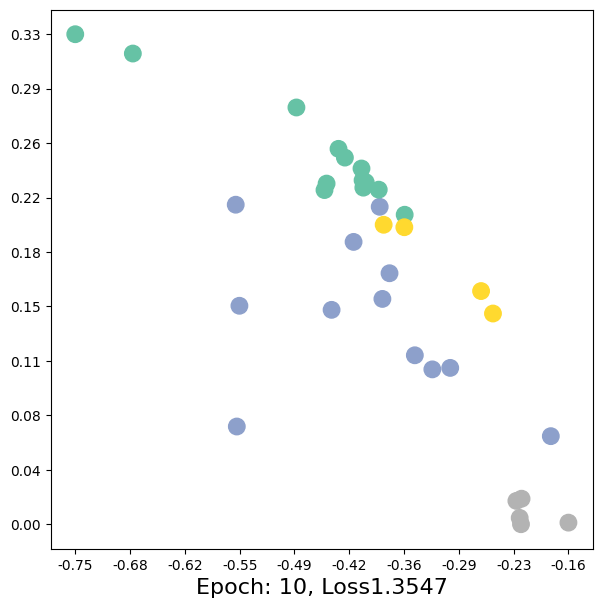

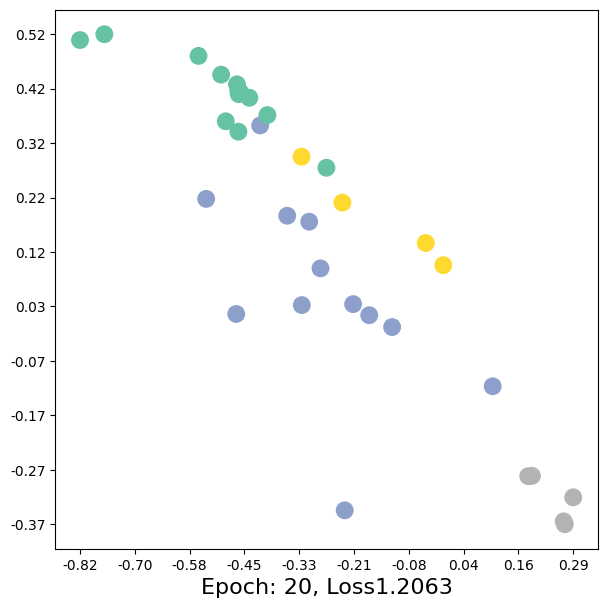

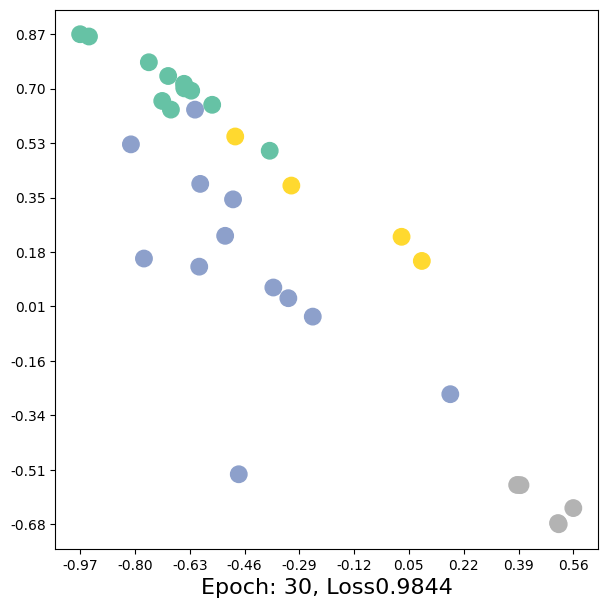

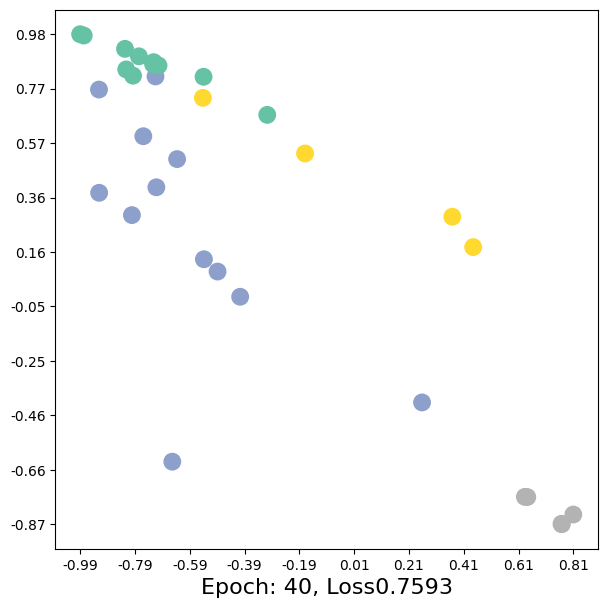

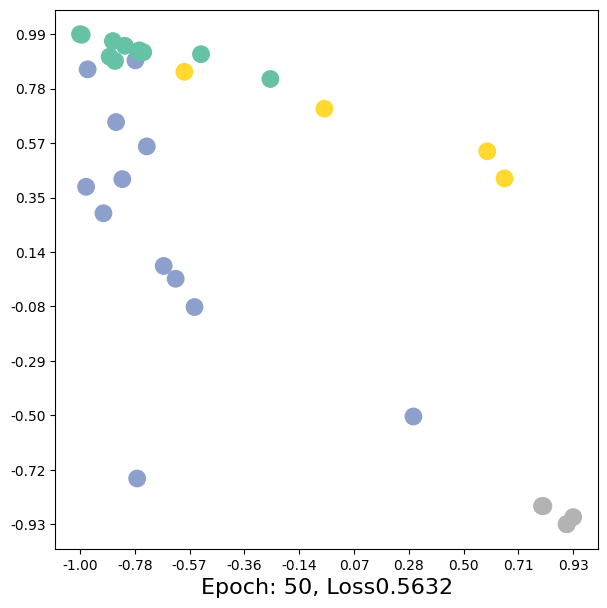

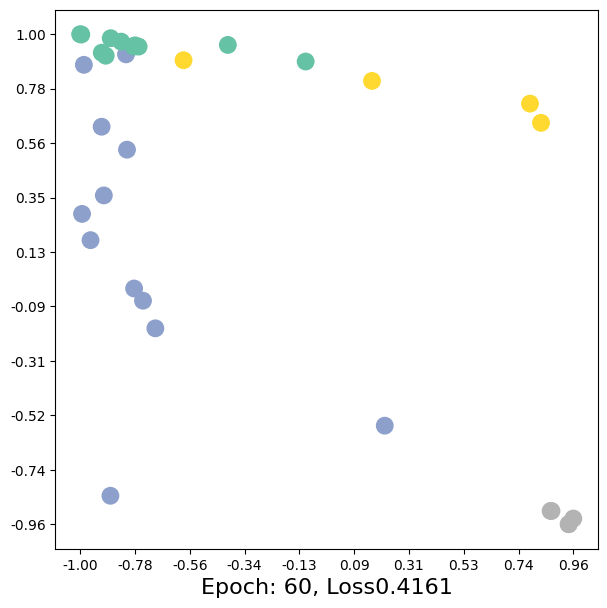

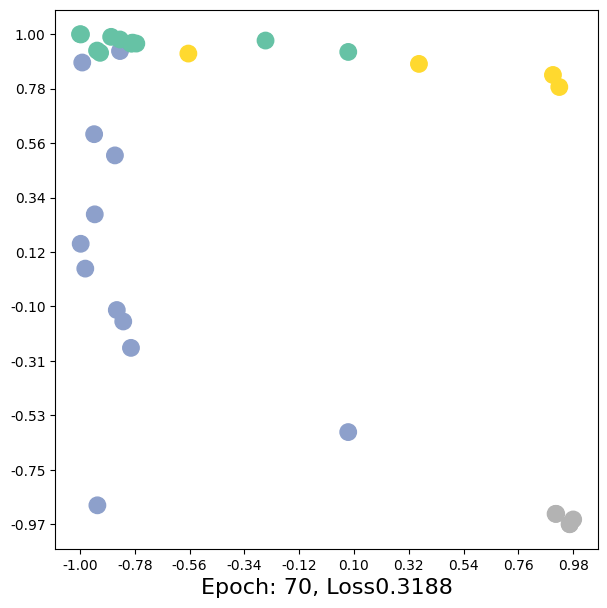

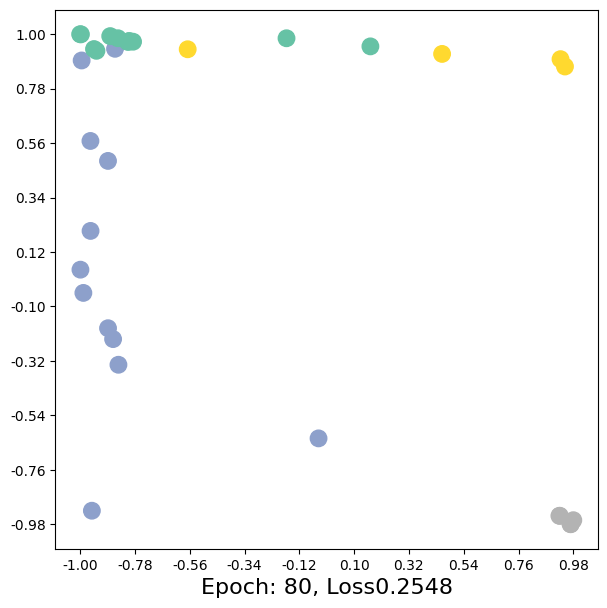

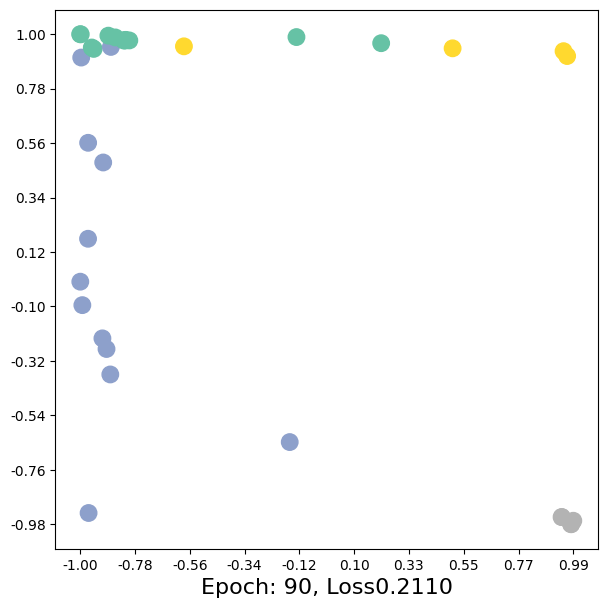

In [15]:
import time 

model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask],data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h

model.train()
for epoch in range(100):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.5)
